## Lab 7.01 Neural Network Binary Classification
_By Jeff Hale_

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


This lab uses a small [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) provided by the Cleveland Clinic Foundation for Heart Disease. The goal is to predict whether a patient has heart disease (the *target* column).

We suggest running this lab in [Google Colab](https://colab.research.google.com/). 

Go *File*->*Upload notebook* to upload this notebook to colab.

If you are working in Colab and want to see if you can get a speed boost, set your runtime to *TPU* by going to *Runtime*->*Change runtime type* in the menu above. 

The processor type won't make a big difference with this small dataset and small networks, but it's good to know how to change the processor.

### Read data and load using pandas

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

Retrieve the csv file containing the heart dataset that ships with TensorFlow.

In [2]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

16384/13273 [=====================================] - 0s 0us/step


#### Load the csv file using pandas.

In [3]:
df = pd.read_csv(csv_file)

#### Inspect

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


#### Check the value counts of the column that's an object

In [6]:
df['thal'].value_counts()

normal        168
reversible    115
fixed          18
1               1
2               1
Name: thal, dtype: int64

You could load data into a format for TensorFlow using `tf.data.Dataset`, but these are unwieldly - it's a serious pain to create a validation dataset from a TF dataset. You used to have to make your data into NumPy arrays for TensorFlow. Now you can just keep them as pandas DataFrames!

#### Set up X and y

In [7]:
X = df.drop(columns = 'target')
y = df['target']

In [8]:
X.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal


In [9]:
y.head(2)

0    0
1    1
Name: target, dtype: int64

#### Train-test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 5)

Convert `thal` column to numeric

### Let's use a friendlier OHE! 🎉

In [12]:
!pip install category_encoders

     |████████████████████████████████| 81kB 5.7MB/s 


In [13]:
from category_encoders import OneHotEncoder as OHE

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
ohe = OHE(use_cat_names = True)
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [15]:
X_train_encoded.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal_normal,thal_reversible,thal_fixed,thal_2
56,44,1,3,140,235,0,2,180,0,0.0,1,0,1,0,0,0
227,47,1,3,130,253,0,0,179,0,0.0,1,0,1,0,0,0


## StandardScale for better performance

In [16]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_encoded)
X_test_scaled = ss.transform(X_test_encoded)

#### Set the TensorFlow random seed

In [17]:
tf.random.set_seed(5)

## Create and train a model

#### Create model structure

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

In [19]:
model = Sequential()
model.add(Input(X_train_scaled.shape[1],))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

#### Visualize the structure

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                340       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


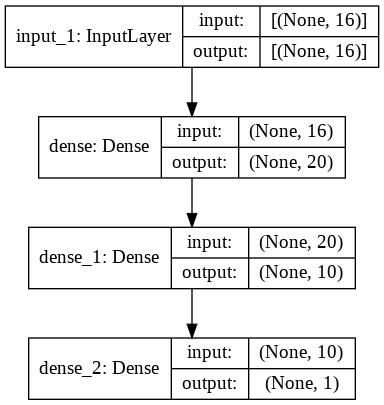

In [21]:
tf.keras.utils.plot_model(
    model,
    show_shapes = True
)

#### Compile

In [22]:
model.compile(loss = 'bce',
              metrics = ['accuracy', 'Recall', 'Precision'],
              optimizer = 'adam'
              )

#### Make an EarlyStopping callback

In [23]:
callback = tf.keras.callbacks.EarlyStopping(patience = 3)

#### Fit the model

In [24]:
history = model.fit(
    X_train_scaled, 
    y_train,  
    epochs=75, 
    callbacks = [callback], 
    batch_size=32, 
    validation_split=.2
    )

Epoch 1/75
6/6 [==============================] - 4s 80ms/step - loss: 0.8463 - accuracy: 0.3827 - recall: 0.8478 - precision: 0.3027 - val_loss: 0.8257 - val_accuracy: 0.3913 - val_recall: 0.8000 - val_precision: 0.2353
Epoch 2/75
6/6 [==============================] - 0s 12ms/step - loss: 0.8328 - accuracy: 0.3716 - recall: 0.8035 - precision: 0.2803 - val_loss: 0.7800 - val_accuracy: 0.4348 - val_recall: 0.8000 - val_precision: 0.2500
Epoch 3/75
6/6 [==============================] - 0s 11ms/step - loss: 0.7569 - accuracy: 0.4533 - recall: 0.8341 - precision: 0.3180 - val_loss: 0.7416 - val_accuracy: 0.5000 - val_recall: 0.8000 - val_precision: 0.2759
Epoch 4/75
6/6 [==============================] - 0s 11ms/step - loss: 0.7131 - accuracy: 0.5298 - recall: 0.8621 - precision: 0.3651 - val_loss: 0.7085 - val_accuracy: 0.5435 - val_recall: 0.8000 - val_precision: 0.2963
Epoch 5/75
6/6 [==============================] - 0s 11ms/step - loss: 0.6802 - accuracy: 0.5957 - recall: 0.7893 - 

#### Plot model performance on the validation data (accuracy, recall, and precision)

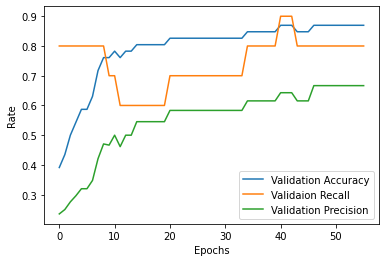

In [25]:
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.plot(history.history['val_recall'], label = 'Validaion Recall')
plt.plot(history.history['val_precision'], label = 'Validation Precision')

plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.legend();

#### Save model
Save as .h5 file extension to save in a single file so can download from colab easily.

In [26]:
model.save('heart_model_1.h5')

In [27]:
! ls

heart_model_1.h5  model.png  sample_data


#### Load model

In [28]:
reloaded_model = tf.keras.models.load_model('heart_model_1.h5')

In [29]:
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                340       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


#### Evaluate on test set 

In [30]:
reloaded_model.evaluate(X_test_scaled, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.4064 - accuracy: 0.7763 - recall: 0.7619 - precision: 0.5714


[0.40639081597328186,
 0.7763158082962036,
 0.761904776096344,
 0.5714285969734192]

#### X_test predictions

In [ ]:
preds = reloaded_model.predict(X_test_scaled)
preds.round()

#### What do those look like?

We have rounded the predictions to show either a 0 or a 1. The original are probabilities, so we need to adjust to get a binary prediction.

#### How is the model performing? 
Let's look at the confusion matrix using TF.

In [37]:
tf.math.confusion_matrix(y_test, preds.round())

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[43, 12],
       [ 5, 16]], dtype=int32)>

Or just use sklearn's confusion matrix. 

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

In [39]:
confusion_matrix(y_test, preds.round())

array([[43, 12],
       [ 5, 16]])

In [40]:
tn, fp, fn, tp = confusion_matrix(y_test, preds.round()).ravel()
tn

43

#### Evaluate with other metrics

In [44]:
preds = preds.round()

In [45]:
pd.DataFrame(classification_report(y_test, preds, output_dict=True)).T.round(2)

,precision,recall,f1-score,support
0,0.90,0.78,0.83,55.00
1,0.57,0.76,0.65,21.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.73,0.77,0.74,76.00
weighted avg,0.81,0.78,0.78,76.00


We are more precise in predicting that a patient does not have heart disease, but only 57% of our guesses that a patient has heart disease are accurate. This can also be seen in the f1 score where the 0 row (does not have heart disease) is at 83%, but the 1 row (has heart disease) is only 65%.

### Make a null model

In [46]:
y.value_counts(normalize = True)

0    0.726073
1    0.273927
Name: target, dtype: float64

Our null model shows a 72.6% accuracy.

## Can you make a better model?

Change the model architecture and see if you can make a better model. Add nodes, dense layers, and dropout layers.

In [54]:
model2 = Sequential()
model2.add(Input(X_train_scaled.shape[1],))
model2.add(Dense(70, activation = 'relu'))
model2.add(Dense(100, activation = 'relu'))
model2.add(Dense(80, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(loss = 'bce',
              metrics = ['accuracy', 'Recall', 'Precision'],
              optimizer = 'adam'
              )

callback = tf.keras.callbacks.EarlyStopping(patience = 5)

history = model2.fit(
    X_train_scaled, 
    y_train,  
    epochs=100, 
    callbacks = [callback], 
    batch_size=32, 
    validation_split=.2
    )

Epoch 1/100
6/6 [==============================] - 1s 73ms/step - loss: 0.6881 - accuracy: 0.5370 - recall: 0.1529 - precision: 0.2024 - val_loss: 0.5756 - val_accuracy: 0.7826 - val_recall: 0.1000 - val_precision: 0.5000
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5328 - accuracy: 0.8051 - recall: 0.3437 - precision: 0.8923 - val_loss: 0.4629 - val_accuracy: 0.8696 - val_recall: 0.5000 - val_precision: 0.8333
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4356 - accuracy: 0.8424 - recall: 0.5161 - precision: 0.8764 - val_loss: 0.3853 - val_accuracy: 0.8478 - val_recall: 0.6000 - val_precision: 0.6667
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3564 - accuracy: 0.8701 - recall: 0.7299 - precision: 0.7999 - val_loss: 0.3411 - val_accuracy: 0.8696 - val_recall: 0.8000 - val_precision: 0.6667
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 0.3376 - accuracy: 0.8616 - recall: 0.75

#### Save your best model. 


In [55]:
model2.save('heart_model_2.h5')

### Compare with other algorithms
Compare your best neural net model to scikit-learn's LogisticRegression, SVM, and GradientBoostingClassifier. Hyperparameter search for good options.

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC

In [60]:
logr = LogisticRegression()
logr.fit(X_train_scaled, y_train)
logr.score(X_train_scaled, y_train)

0.8678414096916299

In [61]:
logr.score(X_test_scaled, y_test)

0.868421052631579

In [66]:
gb = GradientBoostingRegressor(max_depth = 5)
gb.fit(X_train_scaled, y_train)
gb.score(X_train_scaled, y_train)

0.9980780079091491

In [67]:
gb.score(X_test_scaled, y_test)

0.044587410933012106

In [84]:
svc = SVC()
svc.fit(X_train_scaled, y_train)
svc.score(X_train_scaled, y_train)

0.9251101321585903

In [85]:
svc.score(X_test_scaled, y_test)

0.8289473684210527

#### Which model performs best in terms of F1 Score?

In [72]:
from sklearn.metrics import f1_score

In [75]:
logr_preds = logr.predict(X_test_scaled)
f1_score(y_test, logr_preds)

0.7619047619047619

In [80]:
gb_preds = gb.predict(X_test_scaled)
f1_score(y_test, gb_preds.round())

0.5

In [87]:
svc_preds = svc.predict(X_test_scaled)
f1_score(y_test, svc_preds)

0.6976744186046512

Logistic Regression performs the best in terms of F1 score

#### What does the F1 Score mean in a few words?

The F1 Score is a weighted average of the precision and recall, which is good when measuring a model with uneven class distribution (as we do in this case).

#### Which model would you recommend for use? Why?

I would use the Logistic Regression model because it scored highest on accuracy and f1 score. It is not overfit and can guess 86.8% of my test set correctly.


#### Download your notebook and put it in your submission folder. 🎉